## Cooling Tank Model

This notebook describes the optimization of the tank model described in `tank_model.py`. This model was developed in the fmdtools package, and requires its installation to simulate.

In [1]:
import sys
sys.path.append('../')
import numpy as np
import scipy as sp
import time
import itertools
import random
from scipy.optimize import minimize
import pandas as pd

import fmdtools.faultsim.propagate as propagate
import fmdtools.resultdisp as rd
from tank_model import Tank
from fmdtools.modeldef import SampleApproach

import matplotlib.pyplot as plt

# Simulation

### Verifying the nominal state:

In the nominal state, no change in system state should occurs.

In [2]:
mdl = Tank()
endresults, resgraph, mdlhist = propagate.nominal(mdl)

In [3]:
mdlhist.keys()

dict_keys(['flows', 'functions', 'time'])

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

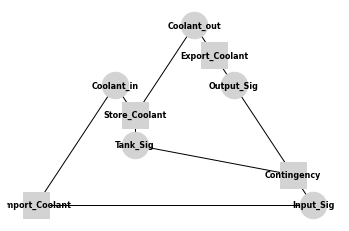

In [4]:
rd.graph.show(resgraph)

C:\Users\dhulse\Anaconda3\lib\site-packages\fmdtools\resultdisp\plot.py:254: UserWarning: Deprecated function. Use resultdisp.plot.mdlhists instead.
  warnings.warn("Deprecated function. Use resultdisp.plot.mdlhists instead.")


(<Figure size 432x1728 with 24 Axes>,
 array([<AxesSubplot:title={'center':'flows Coolant_in effort'}>,
        <AxesSubplot:title={'center':'flows Coolant_in rate'}>,
        <AxesSubplot:title={'center':'flows Coolant_out effort'}>,
        <AxesSubplot:title={'center':'flows Coolant_out rate'}>,
        <AxesSubplot:title={'center':'flows Input_Sig indicator'}>,
        <AxesSubplot:title={'center':'flows Input_Sig action'}>,
        <AxesSubplot:title={'center':'flows Tank_Sig indicator'}>,
        <AxesSubplot:title={'center':'flows Tank_Sig action'}>,
        <AxesSubplot:title={'center':'flows Output_Sig indicator'}>,
        <AxesSubplot:title={'center':'flows Output_Sig action'}>,
        <AxesSubplot:title={'center':'functions Import_Coolant faults Leak'}>,
        <AxesSubplot:title={'center':'functions Import_Coolant faults Blockage'}>,
        <AxesSubplot:title={'center':'functions Import_Coolant open'}>,
        <AxesSubplot:title={'center':'functions Import_Coolant mode

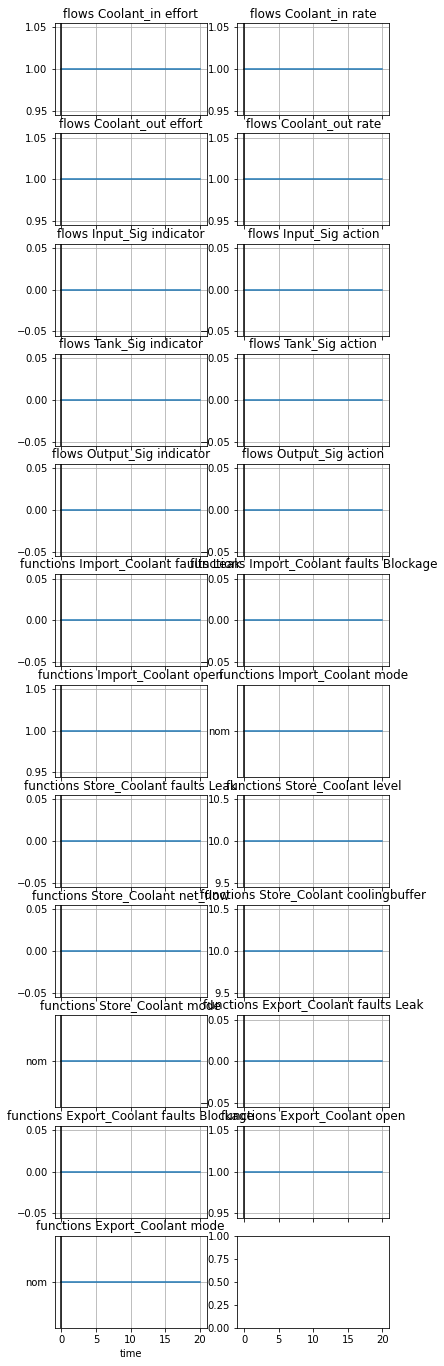

In [5]:
rd.plot.mdlhistvals(mdlhist)

### What happens under component faults?


Here we model a leak of the tank. As shown, the coolant leaks until there is no more coolant left in the tank. While this results in a warning signal, the default contingency management policy is to take no actions to alleviate the condition.

C:\Users\dhulse\Anaconda3\lib\site-packages\fmdtools\resultdisp\plot.py:254: UserWarning: Deprecated function. Use resultdisp.plot.mdlhists instead.
  warnings.warn("Deprecated function. Use resultdisp.plot.mdlhists instead.")


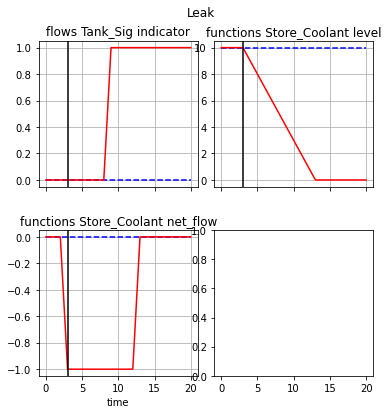

In [7]:
endresults, resgraph, mdlhist = propagate.one_fault(mdl,'Store_Coolant','Leak', time=3, gtype='normal')

fig, ax = rd.plot.mdlhistvals(mdlhist, fault='Leak', time=3, fxnflowvals={'Store_Coolant':['level', 'net_flow'], 'Tank_Sig':['indicator'], 'Valve1_Sig':['action']}, legend=False) #,
#fig.axes[3].remove()
fig.set_figheight(6)
fig.set_figwidth(6)
fig.subplots_adjust(top = 0.9, wspace=0.1, hspace=0.3)

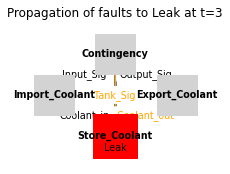

In [8]:
#add graph view to figure
import networkx as nx
graph_fig, graph_ax = rd.graph.show(resgraph,faultscen='Leak', time=3, scale=0.8, gtype='normal', pos=nx.shell_layout(resgraph))
graph_ax.figure = fig
fig.axes.append(graph_ax)
fig.add_axes(graph_ax)
graph_ax.set_position([0.6,0.10,0.5,0.5])
graph_ax.margins(0.3)

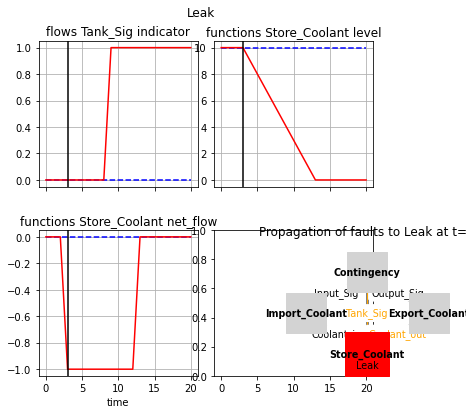

In [9]:
fig

In [10]:
fig.savefig('tank_behavior.pdf', format="pdf", bbox_inches = 'tight', pad_inches = 0.0)

### Full set of modes

The tank leak mode will not be the only mode considered, but also leak and blockage faults in the Imput/Output blocks.

In [11]:
app_joint_faults = SampleApproach(mdl)
endclasses, mdlhists = propagate.approach(mdl, app_joint_faults)
fmea_tab = rd.tabulate.simplefmea(endclasses)
fmea_tab

SCENARIOS COMPLETE: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 278.51it/s]


,rate,cost,expected cost
"Import_Coolant Leak, t=0",0.000002,2100000.0,350000.000000
"Import_Coolant Blockage, t=0",0.000002,2100000.0,350000.000000
"Store_Coolant Leak, t=0",0.000002,1000000.0,166666.666667
"Export_Coolant Leak, t=0",0.000002,1000000.0,166666.666667
"Export_Coolant Blockage, t=0",0.000002,100000.0,16666.666667
nominal,1.000000,0.0,0.000000


In [12]:
print(fmea_tab.to_latex(float_format="%.2g"))

\begin{tabular}{lrrr}
\toprule
{} &    rate &    cost &  expected cost \\
\midrule
Import\_Coolant Leak, t=0     & 1.7e-06 & 2.1e+06 &        3.5e+05 \\
Import\_Coolant Blockage, t=0 & 1.7e-06 & 2.1e+06 &        3.5e+05 \\
Store\_Coolant Leak, t=0      & 1.7e-06 &   1e+06 &        1.7e+05 \\
Export\_Coolant Leak, t=0     & 1.7e-06 &   1e+06 &        1.7e+05 \\
Export\_Coolant Blockage, t=0 & 1.7e-06 &   1e+05 &        1.7e+04 \\
nominal                      &       1 &       0 &              0 \\
\bottomrule
\end{tabular}



### Optimization

Here we compare the optimization of the response of this system using bilevel and alternating architectures

In [13]:
import importlib
import tank_opt
import multiprocessing as mp
importlib.reload(tank_opt)
pool = mp.Pool(5)

alternating optimization structure

In [14]:
result_alt, llargs_alt, fhist_alt, thist_alt, xdhist_alt = tank_opt.alternating_opt(pool=pool)

[22.05   0.475]
[22.05   0.475]
[22.05   0.475]
[22.05   0.475]
[22.05   0.475]
[22.05   0.475]
[22.0171875   0.48164062]
[22.00078125  0.45996094]
[22.00078125  0.45996094]
[22.00078125  0.45996094]
[22.00283203  0.4501709 ]
[22.00283203  0.4501709 ]
[22.00283203  0.4501709 ]
[22.00283203  0.4501709 ]
[22.00283203  0.4501709 ]
[22.00071716  0.45401688]
[22.00376129  0.43635979]
[22.00105362  0.4352232 ]
[22.00578804  0.39934072]
[22.00273991  0.37912631]
[22.01068468  0.29725416]
[22.0085608   0.21588925]
[2.20233884e+01 1.14624918e-02]
[22.02126453  0.        ]
[22.01544363  0.11081025]
[22.00828543  0.14329039]
[22.00828543  0.14329039]
[22.00638767  0.08860283]
[22.00638767  0.08860283]
[22.00638767  0.08860283]
[2.20007596e+01 6.00495249e-03]
[2.20007596e+01 6.00495249e-03]
[2.20007596e+01 6.00495249e-03]
[2.20007596e+01 6.00495249e-03]
[2.20007596e+01 6.00495249e-03]
[2.20007596e+01 6.00495249e-03]
[22.00024225  0.        ]
[22.00024225  0.        ]
[2.20001588e+01 4.50371437e-03

['iter 28: ', 277999.99999999994]
['iter 29: ', 277999.99999999994]
['iter 30: ', 277999.99999999994]
['iter 31: ', 277999.99999999994]
['iter 32: ', 277999.99999999994]
['iter 33: ', 277999.99999999994]
['iter 34: ', 277999.99999999994]
['iter 35: ', 277999.99999999994]
['iter 36: ', 277999.99999999994]
['iter 37: ', 277999.99999999994]
['iter 38: ', 277999.99999999994]
['iter 39: ', 277999.99999999994]
['iter 40: ', 277999.99999999994]
['iter 41: ', 277999.99999999994]
['iter 42: ', 277999.99999999994]
['iter 43: ', 277999.99999999994]
['iter 44: ', 277999.99999999994]
['iter 45: ', 277999.99999999994]
['iter 46: ', 277999.99999999994]
['iter 47: ', 277999.99999999994]
['iter 48: ', 277999.99999999994]
['iter 49: ', 277999.99999999994]
['iter 50: ', 277999.99999999994]
['iter 51: ', 277999.99999999994]
['iter 52: ', 277999.99999999994]
['iter 53: ', 277999.99999999994]
['iter 54: ', 277999.99999999994]
['iter 55: ', 277999.99999999994]
['iter 56: ', 277999.99999999994]
['iter 57: ', 

[20.03125  0.     ]
[20.015625  0.      ]
[20.015625  0.      ]
[20.015625  0.      ]
[20.0078125  0.       ]
[20.0078125  0.       ]
[20.0078125  0.       ]
[20.00390625  0.        ]
[20.00390625  0.        ]
[20.00390625  0.        ]
[20.00195312  0.        ]
[20.00195312  0.        ]
[20.00195312  0.        ]
[20.00097656  0.        ]
[20.00097656  0.        ]
[20.00097656  0.        ]
[20.00048828  0.        ]
[20.00048828  0.        ]
[20.00048828  0.        ]
[20.00024414  0.        ]
[20.00024414  0.        ]
[20.00024414  0.        ]
[20.00012207  0.        ]
[20.00012207  0.        ]
[20.00012207  0.        ]
[20.00006104  0.        ]
[20.00006104  0.        ]
[20.00006104  0.        ]
[20.00003052  0.        ]
[20.00003052  0.        ]
[20.00003052  0.        ]
[20.00001526  0.        ]
[20.00001526  0.        ]
[20.00001526  0.        ]
[20.00000763  0.        ]
[20.00000763  0.        ]
[20.00000763  0.        ]
[20.00000381  0.        ]
[20.00000381  0.        ]
[20.000003

['iter 28: ', 343666.6666666666]
['iter 29: ', 343666.6666666666]
['iter 30: ', 343666.6666666666]
['iter 31: ', 343666.6666666666]
['iter 32: ', 343666.6666666666]
['iter 33: ', 343666.6666666666]
['iter 34: ', 343666.6666666666]
['iter 35: ', 343666.6666666666]
['iter 36: ', 343666.6666666666]
['iter 37: ', 343666.6666666666]
['iter 38: ', 343666.6666666666]
['iter 39: ', 343666.6666666666]
['iter 40: ', 343666.6666666666]
['iter 41: ', 343666.6666666666]
['iter 42: ', 343666.6666666666]
['iter 43: ', 343666.6666666666]
['iter 44: ', 343666.6666666666]
['iter 45: ', 343666.6666666666]
['iter 46: ', 343666.6666666666]
['iter 47: ', 343666.6666666666]
['iter 48: ', 343666.6666666666]
['iter 49: ', 343666.6666666666]
['iter 50: ', 343666.6666666666]
['iter 51: ', 343666.6666666666]
['iter 52: ', 343666.6666666666]
['iter 53: ', 343666.6666666666]
['iter 54: ', 343666.6666666666]
['iter 55: ', 343666.6666666666]
['iter 56: ', 343666.6666666666]
['iter 57: ', 343666.6666666666]
['iter 58:

In [16]:
result_alt.fun

453666.6668231288

In [31]:
result_alt_nocr, llargs_alt_nocr, fhist_alt_nocr, thist_alt_nocr, xdhist_alt_nocr = tank_opt.alternating_opt(option="without_cr",pool=pool)

[18.9     0.5375]
[17.85     0.50625]
[13.125     0.565625]
[10.         0.5328125]
[10.         0.5328125]
[10.         0.5328125]
[10.          0.45390625]
[10.          0.36132812]
[10.          0.15722656]
[10.  0.]
[10.  0.]
[10.  0.]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 13
         Function evaluations: 24
['iter 0: ', 906666.6666666666]
['iter 1: ', 899999.9999999999]
['iter 2: ', 899999.9999999999]
['iter 3: ', 899999.9999999999]
['iter 4: ', 899999.9999999999]
['iter 5: ', 899999.9999999999]
['iter 6: ', 899999.9999999999]
['iter 7: ', 896666.6666666666]
['iter 8: ', 896666.6666666666]
['iter 9: ', 896666.6666666666]
['iter 10: ', 896666.6666666666]
['iter 11: ', 896666.6666666666]
['iter 12: ', 896666.6666666666]
['iter 13: ', 896666.6666666666]
['iter 14: ', 896666.6666666665]
['iter 15: ', 896666.6666666665]
['iter 16: ', 896666.6666666665]
['iter 17: ', 893333.3333333333]
['iter 18: ', 893333.3333333333]
['ite

['iter 26: ', 893333.3333333333]
['iter 27: ', 893333.3333333333]
['iter 28: ', 893333.3333333333]
['iter 29: ', 893333.3333333333]
['iter 30: ', 893333.3333333333]
['iter 31: ', 893333.3333333333]
['iter 32: ', 893333.3333333333]
['iter 33: ', 893333.3333333333]
['iter 34: ', 893333.3333333333]
['iter 35: ', 893333.3333333333]
['iter 36: ', 893333.3333333333]
['iter 37: ', 893333.3333333333]
['iter 38: ', 893333.3333333333]
['iter 39: ', 893333.3333333333]
['iter 40: ', 893333.3333333333]
['iter 41: ', 893333.3333333333]
['iter 42: ', 893333.3333333333]
['iter 43: ', 893333.3333333333]
['iter 44: ', 893333.3333333333]
['iter 45: ', 893333.3333333333]
['iter 46: ', 893333.3333333333]
['iter 47: ', 893333.3333333333]
['iter 48: ', 893333.3333333333]
['iter 49: ', 893333.3333333333]
['iter 50: ', 893333.3333333333]
['iter 51: ', 893333.3333333333]
['iter 52: ', 893333.3333333333]
['iter 53: ', 893333.3333333333]
['iter 54: ', 893333.3333333333]
['iter 55: ', 893333.3333333333]
['iter 56:

In [35]:
result_bi, llargs_bi, bestf_bi, bestxdes_bi = tank_opt.bilevel_opt(pool=pool)

time: 5.78708553314209 fval: 336333.3333333334 xdes: [21.   0.5]
time: 11.541545391082764 fval: 327919.1666666666 xdes: [22.05  0.5 ]
time: 17.549811840057373 fval: 317089.5833333334 xdes: [21.     0.525]
time: 23.64339828491211 fval: 325675.4166666666 xdes: [22.05   0.525]
[21.     0.525]
time: 29.43894338607788 fval: 317191.6666666666 xdes: [21.    0.55]
[21.     0.525]
time: 35.323543548583984 fval: 310810.8333333334 xdes: [19.95  0.55]
time: 41.21765923500061 fval: 306774.0625000001 xdes: [18.9     0.5625]
[18.9     0.5625]
time: 46.798969745635986 fval: 323332.3958333335 xdes: [18.9     0.5375]
time: 52.59801411628723 fval: 304691.34765625006 xdes: [20.475     0.546875]
[20.475     0.546875]
time: 58.59948801994324 fval: 296763.8997395835 xdes: [18.375     0.584375]
time: 65.14953708648682 fval: 325212.13378906273 xdes: [17.0625     0.6140625]
[18.375     0.584375]
time: 70.97677087783813 fval: 326853.93229166674 xdes: [19.95     0.56875]
time: 76.93263721466064 fval: 310962.23795

time: 560.0846359729767 fval: 286709.4112648579 xdes: [18.00003773  0.58098507]
time: 566.0781786441803 fval: 286709.7582671623 xdes: [18.00005887  0.58098401]
[18.00001545  0.58098156]
time: 571.8756184577942 fval: 305708.6447581001 xdes: [17.99999431  0.58098263]
time: 577.687680721283 fval: 289042.8132224451 xdes: [18.00004273  0.58098366]
time: 583.4466271400452 fval: 286709.2015115846 xdes: [18.00002659  0.58098332]
time: 589.1806263923645 fval: 286709.3750124054 xdes: [18.00003716  0.58098279]
[18.00001545  0.58098156]
time: 595.5286526679993 fval: 286708.81825824594 xdes: [18.00000488  0.5809821 ]
[18.00001545  0.58098156]
time: 601.2216658592224 fval: 307041.9418391422 xdes: [17.99999374  0.58098034]
time: 607.6096754074097 fval: 285709.05325992167 xdes: [18.00001838  0.58098257]
[18.00001545  0.58098156]
time: 613.448739528656 fval: 285709.2267605768 xdes: [18.00002895  0.58098204]
time: 619.3696990013123 fval: 285709.1246348855 xdes: [18.00002293  0.58098206]
[18.00001545  0.

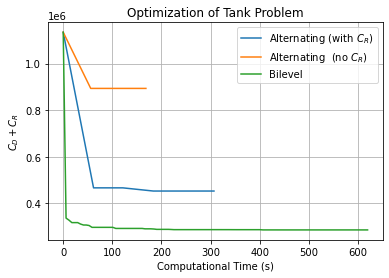

In [58]:
fig = plt.figure()
fhist_alt_plot = [min(fhist_alt[:f+1]) for f,_ in enumerate(fhist_alt)]
plt.plot(thist_alt, fhist_alt_plot, label="Alternating (with $C_R$)")

fhist_alt_nocr_plot = [min(fhist_alt_nocr[:f+1]) for f,_ in enumerate(fhist_alt_nocr)]
plt.plot(thist_alt_nocr, fhist_alt_nocr_plot, label="Alternating  (no $C_R$)")

thist_bilevel_plot = [0]+llargs_bi['thist']
fhist_bilevel_plot = [fhist_alt[0]]+llargs_bi['fhist']
fhist_bilevel_plot = [min(fhist_bilevel_plot[:f+1]) for f,_ in enumerate(fhist_bilevel_plot)]
plt.plot(thist_bilevel_plot, fhist_bilevel_plot, label="Bilevel")
#plt.plot(t, [fhist_alt[0]]+llargs_bi['fhist'], label="Bilevel")
plt.title("Optimization of Tank Problem")
plt.grid()
plt.ylabel("$C_D+C_R$")
#plt.yscale("log")
plt.xlabel("Computational Time (s)")
plt.legend()

In [59]:
fig.savefig('tank_optimization.pdf', format="pdf", bbox_inches = 'tight', pad_inches = 0.0)

In [61]:
tank_opt.x_to_totcost3(result_bi['x'],llargs_bi['ll_optx'][0],llargs_bi['ll_optx'][1])

285708.9917586209

In [62]:
tank_opt.x_to_totcost3(result_alt['x'],llargs_alt['ll_optx'][0],llargs_alt['ll_optx'][1])

452666.6668231288

In [64]:
result_bi['x']

array([18.00001545,  0.58098156])

In [65]:
result_alt['x']

array([20.00000001,  0.        ])

In [66]:
llargs_bi['fhist'][-1]

285709.1246348855

In [67]:
list(xdhist_alt[1])

[22.000000002218062, 0.0]

In [81]:
tab = pd.DataFrame(columns = ["$x_t$", "$x_l$", "$f^*$", "time"])
tab.loc['Bilevel'] = list(result_bi['x']) +  [result_bi['fun'], llargs_bi['thist'][-1]]
tab.loc['Alt. (no $C_R$)'] = list(result_alt_nocr['x']) + [llargs_alt_nocr['ll_opt'], thist_alt_nocr[-1]]
tab.loc['Alt. (with $C_R$)'] = list(result_alt['x']) + [result_alt['fun'], thist_alt[-1]]
tab.loc['Seq. (with $C_R$)'] = list(xdhist_alt[1]) + [fhist_alt[1], thist_alt[1]]
tab.loc['Seq. (no $C_R$)'] = list(xdhist_alt_nocr[1]) + [fhist_alt_nocr[1], thist_alt_nocr[1]]

In [82]:
tab

,$x_t$,$x_l$,$f^*$,time
Bilevel,18.000015,0.580982,285708.991759,619.369699
Alt. (no $C_R$),10.000000,0.000000,893333.333333,168.275383
Alt. (with $C_R$),20.000000,0.000000,452666.666823,306.776320
Seq. (with $C_R$),22.000000,0.000000,466333.333389,61.702104
Seq. (no $C_R$),10.000000,0.000000,893333.333333,55.957946


In [83]:
print(tab.to_latex(float_format="%.2g" ))

\begin{tabular}{lrrrr}
\toprule
{} &  \$x\_t\$ &  \$x\_l\$ &   \$f\textasciicircum *\$ &    time \\
\midrule
Bilevel           &     18 &   0.58 & 2.9e+05 & 6.2e+02 \\
Alt. (no \$C\_R\$)   &     10 &      0 & 8.9e+05 & 1.7e+02 \\
Alt. (with \$C\_R\$) &     20 &      0 & 4.5e+05 & 3.1e+02 \\
Seq. (with \$C\_R\$) &     22 &      0 & 4.7e+05 &      62 \\
Seq. (no \$C\_R\$)   &     10 &      0 & 8.9e+05 &      56 \\
\bottomrule
\end{tabular}



In [71]:
llargs_bi['ll_optx'] - llargs_alt['ll_optx'] 

array([[-1.,  0.,  1., -1.,  1.,  1.,  2.,  1., -1., -1., -1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  2.,  0., -1., -1.,  0.,
         1.],
       [ 0., -2.,  0.,  2.,  0.,  0.,  0.,  1.,  1.,  2., -2.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1., -1., -1.,  0.,  0., -1.,  0.,  0.,
        -1.]])

In [72]:
opt_policy_bi = {"iv":[a-1 for a,b,c in np.ndindex((3,3,3))], "tank":[b-1 for a,b,c in np.ndindex((3,3,3))],"ov":[c-1 for a,b,c in np.ndindex((3,3,3))], "iv_act":[int(i) for i in llargs_bi['ll_optx'][0]], "ov_act":[int(i) for i in llargs_bi['ll_optx'][1]]}
opt_policy_alt = {"iv":[a-1 for a,b,c in np.ndindex((3,3,3))], "tank":[b-1 for a,b,c in np.ndindex((3,3,3))],"ov":[c-1 for a,b,c in np.ndindex((3,3,3))], "iv_act":[int(i) for i in llargs_alt['ll_optx'][0]], "ov_act":[int(i) for i in llargs_alt['ll_optx'][1]]}

In [77]:
#opttab = pd.DataFrame({'bilevel':opt_policy_bi, "alternating":opt_policy_alt})
opttab = pd.DataFrame(opt_policy_bi)
opttab

,iv,tank,ov,iv_act,ov_act
0,-1,-1,-1,-1,1
1,-1,-1,0,0,-1
2,-1,-1,1,1,-1
3,-1,0,-1,-1,1
4,-1,0,0,1,0
5,-1,0,1,1,1
6,-1,1,-1,1,0
7,-1,1,0,1,0
8,-1,1,1,0,0
9,0,-1,-1,0,1


In [76]:
print(opttab.to_latex(index=False))

\begin{tabular}{rrrrr}
\toprule
 iv &  tank &  ov &  iv\_act &  ov\_act \\
\midrule
 -1 &    -1 &  -1 &      -1 &       1 \\
 -1 &    -1 &   0 &       0 &      -1 \\
 -1 &    -1 &   1 &       1 &      -1 \\
 -1 &     0 &  -1 &      -1 &       1 \\
 -1 &     0 &   0 &       1 &       0 \\
 -1 &     0 &   1 &       1 &       1 \\
 -1 &     1 &  -1 &       1 &       0 \\
 -1 &     1 &   0 &       1 &       0 \\
 -1 &     1 &   1 &       0 &       0 \\
  0 &    -1 &  -1 &       0 &       1 \\
  0 &    -1 &   0 &      -1 &      -1 \\
  0 &    -1 &   1 &       0 &       0 \\
  0 &     0 &  -1 &       0 &       0 \\
  0 &     0 &   0 &       0 &       0 \\
  0 &     0 &   1 &       0 &       0 \\
  0 &     1 &  -1 &       0 &      -1 \\
  0 &     1 &   0 &       0 &      -1 \\
  0 &     1 &   1 &       1 &       0 \\
  1 &    -1 &  -1 &       1 &       0 \\
  1 &    -1 &   0 &       0 &      -1 \\
  1 &    -1 &   1 &       0 &       0 \\
  1 &     0 &  -1 &       1 &       1 \\
  1 &     0 & 

## Statistical Comparison

Checking to make sure the previous results generalize.

In [17]:
import importlib
import tank_opt
import multiprocessing as mp
importlib.reload(tank_opt)
pool = mp.Pool(5)

In [18]:
num_replicates= 20 # given simulating all three takes ~30 minutes, 20 replicates should give a 10 hr computational time. 

In [24]:
fstars_bi=[]; fstars_alt_nocr=[]; fstars_alt=[]; fstars_seq=[]; fstars_seq_nocr = [] #init final value vectors
fhists_bi = []; fhists_alt_nocr=[]; fhists_alt =[] #init best history value vectors

for i in range(num_replicates):
    result_alt, llargs_alt, fhist_alt, thist_alt, xdhist_alt = tank_opt.alternating_opt(pool=pool)
    result_alt_nocr, llargs_alt_nocr, fhist_alt_nocr, thist_alt_nocr, xdhist_alt_nocr = tank_opt.alternating_opt(option="without_cr",pool=pool)
    result_bi, llargs_bi, bestf_bi, bestxdes_bi = tank_opt.bilevel_opt(pool=pool)
    
    fstars_bi.append(result_bi['fun']); fstars_alt_nocr.append(llargs_alt_nocr['ll_opt']); fstars_alt.append(result_alt['fun'])
    fstars_seq.append(fhist_alt[1]);    fstars_seq_nocr.append(fhist_alt_nocr[1])
    fhists_bi.append(fhist_bi); fhist_

[22.05   0.475]
[22.05   0.475]
[22.05   0.475]
[22.05   0.475]
[22.05   0.475]
[22.05   0.475]
[22.0171875   0.48164062]
[22.00078125  0.45996094]
[22.00078125  0.45996094]
[22.00078125  0.45996094]
[22.00283203  0.4501709 ]
[22.00283203  0.4501709 ]
[22.00283203  0.4501709 ]
[22.00283203  0.4501709 ]
[22.00283203  0.4501709 ]
[22.00071716  0.45401688]
[22.00376129  0.43635979]
[22.00105362  0.4352232 ]
[22.00578804  0.39934072]
[22.00273991  0.37912631]
[22.01068468  0.29725416]
[22.0085608   0.21588925]
[2.20233884e+01 1.14624918e-02]
[22.02126453  0.        ]
[22.01544363  0.11081025]
[22.00828543  0.14329039]
[22.00828543  0.14329039]
[22.00638767  0.08860283]
[22.00638767  0.08860283]
[22.00638767  0.08860283]
[2.20007596e+01 6.00495249e-03]
[2.20007596e+01 6.00495249e-03]
[2.20007596e+01 6.00495249e-03]
[2.20007596e+01 6.00495249e-03]
[2.20007596e+01 6.00495249e-03]
[2.20007596e+01 6.00495249e-03]
[22.00024225  0.        ]
[22.00024225  0.        ]
[2.20001588e+01 4.50371437e-03

KeyboardInterrupt: 

for saving/reloading results given the simulation time...

In [21]:
import pickle

In [22]:
with open("optim_results.pkl", "wb") as file:
    pickle.dump([fhists_bi, fhists_alt_nocr, fhists_alt, fstars_bi, fstars_alt_notcr, fstars_alt, fstars_seq, fstars_seq_nocr], file)

SyntaxError: invalid syntax (2/ipykernel_22112/3329211327.py, line 1)

In [ ]:
with open("optim_results.pkl", "rb") as file:
    loaded_vars = pickle.load(file)
fhists_bi, fhists_alt_nocr, fhists_alt, fstars_bi, fstars_alt_notcr, fstars_alt, fstars_seq, fstars_seq_nocr = loaded_vars